# How to crawling?

In [20]:
#import custom module
import nre.con as nc
import nre.util as nu
import pandas as pd
from IPython.display import clear_output 
import matplotlib.pyplot as plt
import seaborn as sns

nu.IS_LOGGING = False

## 위치을 이용하여 구역 특정

In [33]:
# loc = nc.NLocation(35.18213, 128.1366) # 진주 충무공동
loc = nc.NLocation(37.49911, 127.065463) # 강남 대치동

cur_region = nc.NRegion('', loc, '0000000000')

# 검색해서 지역 찾기
while True:
    regions = nu.get_region_list(cur_region.no)
    if len(regions) == 0: break
    for i, region in enumerate(regions): 
        print(i, region)
        
    idx = int(input("원하는 도시 인덱스(exit -1) : "))
    clear_output()
    if idx == -1: break
    cur_region = regions[idx]
    
sector = nu.get_sector(cur_region.loc)

print(sector)

경상남도 김해시 어방동 4825011800 loc(35.237800 | 128.903300)


## 매물 조건 생성

In [34]:
addon = nc.NAddon(
    tradeType=[nc.NAddon.TRADE_DEAL, nc.NAddon.TRADE_LEASE], #목표 거래 - 매매, 전세
    estateType=[nc.NAddon.ESTATE_APT, nc.NAddon.ESTATE_OPST] #목표 매물 - 아파트, 오피스텔
)

for poly in sector.map.polys:
    poly

## 조건과 구역을 이용하여 매물 탐색

In [35]:
things = [] # 매물 기록
removed = 0
for dirr in nc.NAddon.DIR_EACH: # 모든 방향 (남향 등등)
    addon.direction = [dirr] # 매물 방향 선택
    res = nu.get_things(sector, addon)
    
    for v in res:
        if sector.map.is_in(v.loc) is False: # 구역 포함되어있는지
            removed += 1 
            continue 
        v.dir = dirr # 매물 방향 정의
        things.append(v)
    
print('올바른 매물 수', len(things), '제거됨', removed)

올바른 매물 수 144 제거됨 152


## 구역 주변 편의 시설 탐색

In [37]:
neighbors = [] # 편의시설 기록
for nType in nc.NNeighbor.EACH: # 모든 편의시설
    values = []
    res = nu.get_neighborhood(sector.loc, nType)
    
    for r in res:
        if sector.map.is_in(r.loc):
            values.append(r)
    neighbors.extend(values)
    print(nType, len(values))
print('Total', len(neighbors))

BUS 19
METRO 0
INFANT 21
PRESCHOOL 3
SCHOOLPOI 6
HOSPITAL 0
PARKING 0
MART 2
CONVENIENCE 21
WASHING 16
BANK 4
OFFICE 1
Total 93


# 편의시설과 매물 간의 거리 탐색

In [38]:
# 500 == 걸어서 5~10분 이내, 버스로 1분
# 1000 == 버스로 1~2분 

standard = nu.get_distance_standard() # 거리 기준

for (key, value) in standard.items():
    print(key, value)

BUS 500
METRO 500
INFANT 750
PRESCHOOL 750
SCHOOLPOI 2000
HOSPITAL 5000
PARKING 500
MART 500
CONVENIENCE 250
WASHING 500
BANK 1000
OFFICE 2000


In [39]:
for thing in things: # 매물
    around = nc.NNeighborAround()
    for nei in neighbors: # 편의시설
        d = nu.distance_between(thing.loc, nei.loc)
        if d <= standard[nei.type]: # meter
            around.increase(nei.type)
    thing.neiAround = around

## 시각화

In [40]:
thing_list = []
around_nei = []

for t in things: 
    thing_list.append(t.get_list())
    around_nei.append(t.neiAround.get_list())

thing_df = pd.DataFrame(data=thing_list ,columns=nc.NThing.HEADER)
nei_df = pd.DataFrame(data=around_nei, columns=nc.NNeighborAround.HEADER)
total_df = pd.concat([thing_df, nei_df], axis=1)

total_df['sector'] = sector.name

total_df['Type'] = total_df['Type'].map({'아파트' : 'APT', '오피스텔' : 'OPS'})

total_df.head(5)

,Name,Type,Build,Dir,minArea,maxArea,representativeArea,floorAreaRatio,minDeal,maxDeal,...,PRESCHOOL,SCHOOLPOI,HOSPITAL,PARKING,MART,CONVENIENCE,WASHING,BANK,OFFICE,sector
0,목연2차,OPS,200108,EE,33.64,33.64,33.0,650,2450,2550,...,3,6,0,0,1,4,6,2,1,어방동
1,동일궁전,APT,200003,EE,95.69,95.69,95.0,174,15200,15200,...,3,6,0,0,2,4,14,4,1,어방동
2,더블리안2차(주상복합),APT,201507,EE,85.12,85.12,85.0,186,16500,16500,...,3,6,0,0,1,4,9,3,1,어방동
3,송학,APT,200008,EE,100.33,100.33,100.0,207,15000,15000,...,2,6,0,0,0,5,5,4,1,어방동
4,더블리안(주상복합),APT,201407,EE,32.66,40.21,40.0,672,5800,7300,...,3,6,0,0,1,4,8,3,1,어방동


In [41]:
nei_df.describe() # 편의시설 접근도

,BUS,METRO,INFANT,PRESCHOOL,SCHOOLPOI,HOSPITAL,PARKING,MART,CONVENIENCE,WASHING,BANK,OFFICE
count,144.000000,144.0,144.000000,144.000000,144.0,144.0,144.0,144.000000,144.0000,144.000000,144.000000,144.0
mean,6.777778,0.0,13.833333,2.333333,6.0,0.0,0.0,1.000000,3.5000,7.166667,2.888889,1.0
std,3.354247,0.0,3.890099,0.946100,0.0,0.0,0.0,0.579365,1.3484,2.843223,0.811724,0.0
min,3.000000,0.0,4.000000,0.000000,6.0,0.0,0.0,0.000000,1.0000,0.000000,2.000000,1.0
25%,4.000000,0.0,12.000000,2.000000,6.0,0.0,0.0,1.000000,2.0000,6.000000,2.000000,1.0
50%,6.500000,0.0,14.000000,3.000000,6.0,0.0,0.0,1.000000,4.0000,6.500000,3.000000,1.0
75%,8.000000,0.0,15.000000,3.000000,6.0,0.0,0.0,1.000000,4.0000,9.000000,4.000000,1.0
max,16.000000,0.0,20.000000,3.000000,6.0,0.0,0.0,2.000000,6.0000,14.000000,4.000000,1.0


In [42]:
total_df.describe()

,representativeArea,floorAreaRatio,minDeal,maxDeal,medianDeal,minLease,maxLease,medianLease,minDealUnit,maxDealUnit,...,INFANT,PRESCHOOL,SCHOOLPOI,HOSPITAL,PARKING,MART,CONVENIENCE,WASHING,BANK,OFFICE
count,144.000000,144.000000,144.000000,144.000000,144.000000,24.000000,24.000000,24.000000,144.000000,144.000000,...,144.000000,144.000000,144.0,144.0,144.0,144.000000,144.0000,144.000000,144.000000,144.0
mean,70.111111,391.000000,11468.333333,14144.444444,12557.222222,10333.333333,13000.000000,10500.000000,499.555556,566.944444,...,13.833333,2.333333,6.0,0.0,0.0,1.000000,3.5000,7.166667,2.888889,1.0
std,30.059873,233.233039,7420.553011,9422.720479,8046.435031,4593.631382,5073.374659,4393.671338,207.814124,214.035216,...,3.890099,0.946100,0.0,0.0,0.0,0.579365,1.3484,2.843223,0.811724,0.0
min,27.000000,0.000000,1700.000000,2150.000000,1950.000000,5000.000000,6000.000000,5500.000000,201.000000,215.000000,...,4.000000,0.000000,6.0,0.0,0.0,0.000000,1.0000,0.000000,2.000000,1.0
25%,34.000000,192.000000,2450.000000,4000.000000,2500.000000,5000.000000,6000.000000,5500.000000,245.000000,331.000000,...,12.000000,2.000000,6.0,0.0,0.0,1.000000,2.0000,6.000000,2.000000,1.0
50%,84.000000,310.500000,11200.000000,15100.000000,13250.000000,10000.000000,16000.000000,10000.000000,512.500000,639.000000,...,14.000000,3.000000,6.0,0.0,0.0,1.000000,4.0000,6.500000,3.000000,1.0
75%,95.000000,635.000000,17500.000000,19500.000000,18000.000000,16000.000000,17000.000000,16000.000000,668.000000,708.000000,...,15.000000,3.000000,6.0,0.0,0.0,1.000000,4.0000,9.000000,4.000000,1.0
max,110.000000,800.000000,23500.000000,36000.000000,27000.000000,16000.000000,17000.000000,16000.000000,914.000000,945.000000,...,20.000000,3.000000,6.0,0.0,0.0,2.000000,6.0000,14.000000,4.000000,1.0


## Dataframe 저장

In [43]:
total_df.to_csv('./csv/house_price_data %s.csv' % sector.name, sep=',', na_rep='NaN', index=False)

In [44]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                144 non-null    object 
 1   Type                144 non-null    object 
 2   Build               144 non-null    object 
 3   Dir                 144 non-null    object 
 4   minArea             144 non-null    object 
 5   maxArea             144 non-null    object 
 6   representativeArea  144 non-null    float64
 7   floorAreaRatio      144 non-null    int64  
 8   minDeal             144 non-null    int64  
 9   maxDeal             144 non-null    int64  
 10  medianDeal          144 non-null    int64  
 11  minLease            24 non-null     float64
 12  maxLease            24 non-null     float64
 13  medianLease         24 non-null     float64
 14  minDealUnit         144 non-null    int64  
 15  maxDealUnit         144 non-null    int64  
 16  medianDe

<AxesSubplot:xlabel='Type', ylabel='minDeal'>

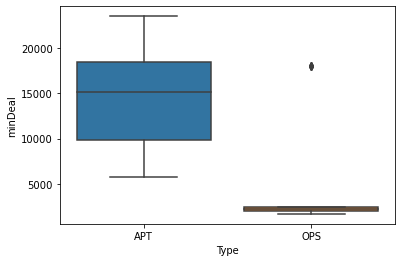

In [46]:
sns.boxplot(x='Type', y = 'minDeal', data=total_df, order=['APT', 'OPS'])